In [69]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import math

## Read the train, validation and test data with predictions

In [146]:
data_train = pd.read_csv('../data/data_train_val.csv')
data_test = pd.read_csv('../data/data_test.csv')


In [147]:
data_train[['Open', 'High', 'pred_high_open', 'actual_high_open', 'Low', 'pred_low_open', 'actual_low_open',  'Close', ]]

,Open,High,pred_high_open,actual_high_open,Low,pred_low_open,actual_low_open,Close
0,546.000000,548.000000,1.379346,2.000000,541.359985,-4.966847,-4.640015,544.159973
1,546.559998,547.119995,1.550162,0.559997,538.400024,-0.807878,-8.159974,545.599976
2,545.760010,550.479980,2.233621,4.719970,542.479980,-0.433728,-3.280030,542.719971
3,553.599976,559.200012,4.208293,5.600036,549.440002,-6.115969,-4.159974,558.320007
4,560.799988,568.400024,5.000463,7.600036,556.559998,-4.734383,-4.239990,566.000000
...,...,...,...,...,...,...,...,...
3309,82.180000,82.279999,-0.003946,0.099999,81.120003,-0.972733,-1.059997,81.500000
3310,81.900002,81.940002,-0.531515,0.040000,80.470001,-4.069467,-1.430001,80.860001
3311,81.180000,81.279999,2.693841,0.099999,79.190002,-6.686567,-1.989998,79.389999
3312,77.980003,78.879997,1.188458,0.899994,77.400002,0.661759,-0.580001,78.800003


## Helper Functions: To calculate annualized return and to find the best delta for any given strategy and data

In [148]:
def calculate_annualized_return(initial_capital, final_capital, num_traded_days):
    # Calculate the total return
    total_return = (final_capital / initial_capital) - 1
    
    # Calculate the number of years
    num_years = num_traded_days / 252  # Assuming 252 trading days in a year
    
    # Calculate the annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1
    
    return annualized_return

In [184]:
def plot_best_delta_strategy(data, tune=True, strategy="blind", optimize="sharpe_ratio", delta_percents=np.arange(0, 0.02, 0.0001), verbose=False, plot_capital=False, initial_capital=10000, risk_free_rate=0.04):

    if tune:
        print(f"Exploring various deltas for the {strategy} strategy....")

        best_sharpe_ratio = None
        best_avg_pnl = None
        best_std_pnl = None
        best_delta_percent = None
        best_pnl = None
        best_profit_days = None
        best_loss_days = None
        best_neutral_days = None
        best_num_traded_days = None
        best_capital = None
        best_annualized_return = None

        if optimize == "sharpe_ratio":
            best_sharpe_ratio = -1 * float('inf')
        
        elif optimize == "capital":
            best_capital = -1 * float('inf')

        elif optimize == "avg_pnl":
            best_avg_pnl = -1 * float('inf')

        elif optimize == "std_pnl":
            best_std_pnl = -1 * float('inf')

        else:
            print('The optimize parameter should be one of sharpe_ratio, capital, avg_pnl, or std_pnl')
            return


        for delta_percent in delta_percents:
            if strategy == "blind":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data, delta_percent=delta_percent, initial_capital=initial_capital)
            elif strategy == "stoploss":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data, delta_percent=delta_percent, initial_capital=initial_capital)
            elif strategy == "long_short":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data, delta_percent=delta_percent, initial_capital=initial_capital)
            else:
                print('The strategy parameter should be one of blind, stoploss, or long_short.')
                return
        
            # Calculate Sharpe Ratio
            excess_pnl = np.array(pnl) * (1-risk_free_rate)
            avg_pnl = np.mean(excess_pnl)
            std_pnl = np.std(excess_pnl)

            sharpe_ratio = avg_pnl / std_pnl     

            # Calculate Annualized Return on Investment
            num_traded_days = num_profit_days + num_loss_days + num_neutral_days
            annualized_return = calculate_annualized_return(initial_capital=initial_capital, final_capital=capital, num_traded_days=num_traded_days)

            if optimize == 'sharpe_ratio':

                if sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_num_traded_days = num_traded_days
                    best_pnl = pnl
                    best_annualized_return = annualized_return

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Sharpe Ratio = {sharpe_ratio}""")
                
            if optimize == 'capital':

                if capital > best_capital:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_num_traded_days = num_traded_days
                    best_pnl = pnl
                    best_annualized_return = annualized_return

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Capital = {capital}""")
            
            if optimize == 'avg_pnl':

                if avg_pnl > best_avg_pnl:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_num_traded_days = num_traded_days
                    best_pnl = pnl
                    best_annualized_return = annualized_return

                if verbose:
                    print(f"""For Delta = {delta_percent*100}%, ===> Average PNL = {avg_pnl}""")
                
            if optimize == "std_pnl":
                if std_pnl > best_std_pnl:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_num_traded_days = num_traded_days
                    best_pnl = pnl
                    best_annualized_return = annualized_return

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Std PNL = {std_pnl}""")
            
        print()

        if optimize == 'sharpe_ratio':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Best Sharpe Ratio = {best_sharpe_ratio:.3f}
                ===> Sum PnL = {sum(best_pnl):.3f}
                ===> Average PNL = {best_avg_pnl:.3f}$
                ===> Std PNL = {best_std_pnl:.3f}
                ===> Final Capital = {best_capital:.2f}$
                ===> Annualized Return = {best_annualized_return*100:.3f}%
                ===> Profitable Days = {(best_profit_days/best_num_traded_days)*100:.2f}%
                ===> Lossy Days = {(best_loss_days/best_num_traded_days)*100:.2f}%
                ===> Neutral Days = {(best_neutral_days/best_num_traded_days)*100:.2f}%
                """)
            
        elif optimize == 'capital':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Sharpe Ratio = {best_sharpe_ratio:.3f}
                ===> Sum PnL = {sum(best_pnl):.3f}
                ===> Average PNL = {best_avg_pnl:.3f}$
                ===> Std PNL = {best_std_pnl:.3f}
                ===> Best Final Capital = {best_capital:.2f}$
                ===> Annualized Return = {best_annualized_return*100:.3f}%
                ===> Profitable Days = {(best_profit_days/best_num_traded_days*100):.2f}%
                ===> Lossy Days = {(best_loss_days/best_num_traded_days*100):.2f}%
                ===> Neutral Days = {(best_neutral_days/best_num_traded_days*100):.2f}%
                """)
            
        elif optimize == 'avg_pnl':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Sharpe Ratio = {best_sharpe_ratio:.3f}
                ===> Sum PnL = {sum(best_pnl):.3f}
                ===> Best Average PNL = {best_avg_pnl:.3f}$
                ===> Std PNL = {best_std_pnl:.3f}
                ===> Final Capital = {best_capital:.2f}$
                ===> Annualized Return = {best_annualized_return*100:.3f}%
                ===> Profitable Days = {(best_profit_days/best_num_traded_days*100):.2f}%
                ===> Lossy Days = {(best_loss_days/best_num_traded_days*100):.2f}%
                ===> Neutral Days = {(best_neutral_days/best_num_traded_days*100):.2f}%
                """)
        
        elif optimize == 'std_pnl':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Sharpe Ratio = {best_sharpe_ratio:.3f}
                ===> Sum PnL = {sum(best_pnl):.3f}
                ===> Average PNL = {best_avg_pnl:.3f}$
                ===> Best Std PNL = {best_std_pnl:.3f}
                ===> Final Capital = {best_capital:.2f}$
                ===> Annualized Return = {best_annualized_return*100:.3f}%
                ===> Profitable Days = {(best_profit_days/best_num_traded_days*100):.2f}%
                ===> Lossy Days = {(best_loss_days/best_num_traded_days*100):.2f}%
                ===> Neutral Days = {(best_neutral_days/best_num_traded_days*100):.2f}%
                """)

        plt.title(f'P&L Plot for Delta = {best_delta_percent*100}%')
        plt.xlabel('Days')
        plt.ylabel('P&L in U.S. Dollars $')
        plt.plot(best_pnl)

        return best_pnl

    else:
        delta_percent = delta_percents[0]
        if strategy == "blind":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data, delta_percent=delta_percent, plot_capital=plot_capital)  
        elif strategy == "stoploss":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data, delta_percent=delta_percent, plot_capital=plot_capital)  
        elif strategy == "long_short":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data, delta_percent=delta_percent,plot_capital=plot_capital)
        else:
            print('The strategy parameter should be one of blind, stoploss, or long_short.')
            return

        # Calculate Sharpe Ratio
        excess_pnl = np.array(pnl) * (1-risk_free_rate)
        avg_pnl = np.mean(excess_pnl)
        std_pnl = np.std(excess_pnl)

        sharpe_ratio = avg_pnl / std_pnl     

        # Calculate Annualized Return on Investment
        num_traded_days = num_profit_days + num_loss_days + num_neutral_days
        annualized_return = calculate_annualized_return(initial_capital=initial_capital, final_capital=capital, num_traded_days=num_traded_days)

        print(f"""Delta for {strategy} Strategy = {delta_percent*100}%,
        ===> Sharpe Ratio = {sharpe_ratio:.3f}
        ===> Sum PnL = {sum(pnl):.3f}
        ===> Average PNL = {avg_pnl:.3f}$
        ===> Std PNL = {std_pnl:.3f}
        ===> Final Capital = {capital:.2f}$
        ===> Annualized Return = {annualized_return*100:.3f}%
        ===> Profitable Days = {(num_profit_days/num_traded_days*100):.2f}%
        ===> Lossy Days = {(num_loss_days/num_traded_days*100):.2f}%
        ===> Neutral Days = {(num_neutral_days/num_traded_days*100):.2f}%
        """)

        plt.title(f'P&L Plot for Delta = {delta_percent*100}%')
        plt.xlabel('Days')
        plt.ylabel('P&L in U.S. Dollars $')
        plt.plot(pnl)

        return pnl

## Strategies

### Blind Strat

In [164]:
def blind_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, max_cap_alloc=50000, plot_capital=False, initial_capital=10000):
    pnl = []

    capital = initial_capital

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0

    capital_list = []

    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open
        
        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta

                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
    
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)


    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

#### Sharpe Ratio Optimization

Exploring various deltas for the blind strategy....

Best Delta for blind Strategy = 0.09000000000000001%,
                ===> Best Sharpe Ratio = 0.421
                ===> Sum PnL = 3592.014
                ===> Average PNL = 1.041$
                ===> Std PNL = 2.470
                ===> Final Capital = 614950.67$
                ===> Annualized Return = 36.781%
                ===> Profitable Days = 63.46%
                ===> Lossy Days = 22.51%
                ===> Neutral Days = 14.03%
                


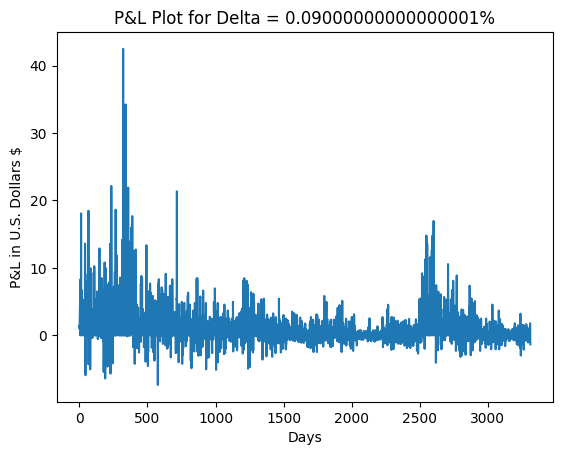

In [165]:
data_train['blind_pnl'] = plot_best_delta_strategy(data=data_train)

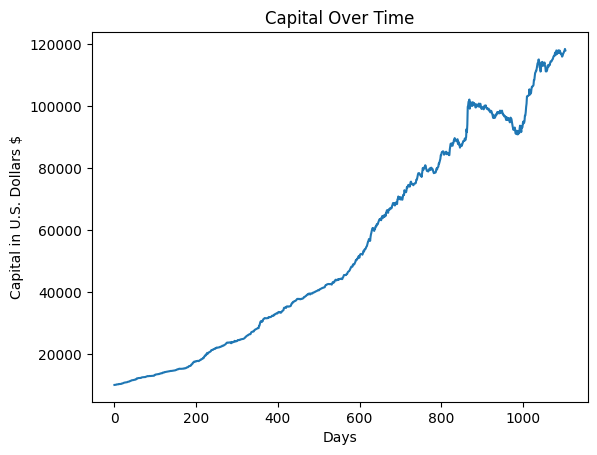

Capital = 118018.32953704963
Delta for blind Strategy = 0.09%,
        ===> Sharpe Ratio = 0.471
        ===> Sum PnL = 1288.069
        ===> Average PNL = 1.119$
        ===> Std PNL = 2.375
        ===> Final Capital = 118018.33$
        ===> Annualized Return = 75.575%
        ===> Profitable Days = 63.17%
        ===> Lossy Days = 22.08%
        ===> Neutral Days = 14.75%
        


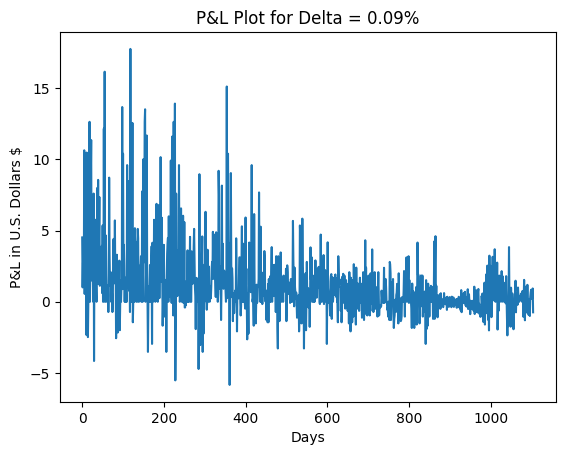

In [166]:
data_test['blind_pnl'] = plot_best_delta_strategy(data=data_test, tune=False, delta_percents=[0.0009], plot_capital=True)

#### Capital Optimization

Exploring various deltas for the blind strategy....

Best Delta for blind Strategy = 0.0%,
                ===> Sharpe Ratio = 0.415
                ===> Sum PnL = 3682.391
                ===> Average PNL = 1.067$
                ===> Std PNL = 2.570
                ===> Best Final Capital = 621674.25$
                ===> Annualized Return = 36.894%
                ===> Profitable Days = 65.87%
                ===> Lossy Days = 22.51%
                ===> Neutral Days = 11.62%
                


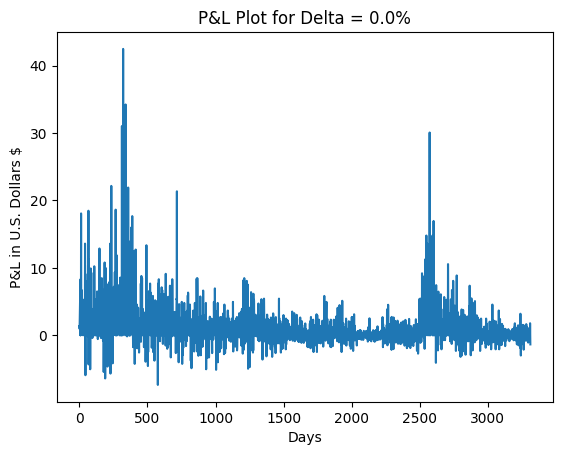

In [167]:
data_train['blind_pnl_capital'] = plot_best_delta_strategy(data=data_train, optimize='capital')

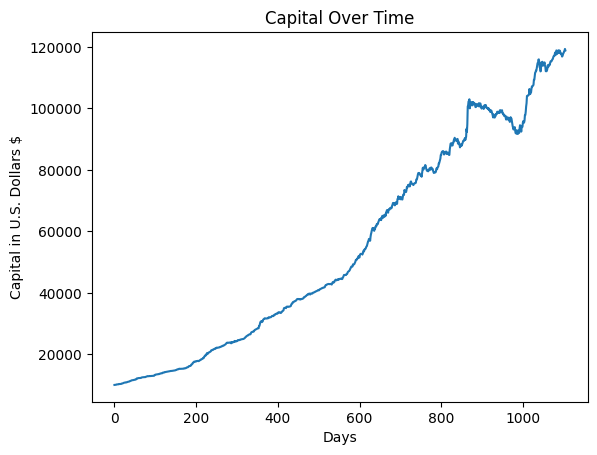

Capital = 118869.97188508397
Delta for blind Strategy = 0%,
        ===> Sharpe Ratio = 0.474
        ===> Sum PnL = 1294.731
        ===> Average PNL = 1.125$
        ===> Std PNL = 2.372
        ===> Final Capital = 118869.97$
        ===> Annualized Return = 75.863%
        ===> Profitable Days = 66.70%
        ===> Lossy Days = 22.08%
        ===> Neutral Days = 11.22%
        


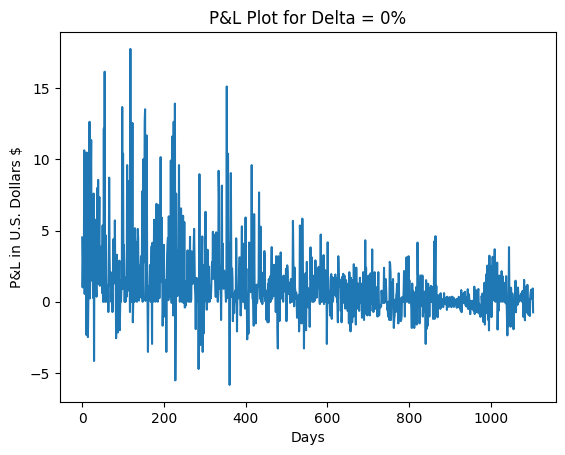

In [168]:
data_test['blind_pnl_capital'] = plot_best_delta_strategy(data=data_test, optimize='capital', tune=False, delta_percents=[0], plot_capital=True)

### Stoploss Strat

In [169]:
def stoploss_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, max_cap_alloc=50000, plot_capital=False, initial_capital=10000):
    pnl = []

    capital = initial_capital

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(predicted_delta)

            # Elif Price dips below Open, then sell @ Open
            elif day_info["Low"] < day_info["Open"]:
                day_return = 0
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(0)
            else:
                # Else, sell at close
                day_return = open-close
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
        
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)

    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

#### Sharpe Ratio Optimization

Exploring various deltas for the stoploss strategy....

Best Delta for stoploss Strategy = 0.0%,
                ===> Best Sharpe Ratio = 0.455
                ===> Sum PnL = 1760.640
                ===> Average PNL = 0.510$
                ===> Std PNL = 1.120
                ===> Final Capital = 249393.74$
                ===> Annualized Return = 27.709%
                ===> Profitable Days = 33.04%
                ===> Lossy Days = 0.91%
                ===> Neutral Days = 66.05%
                


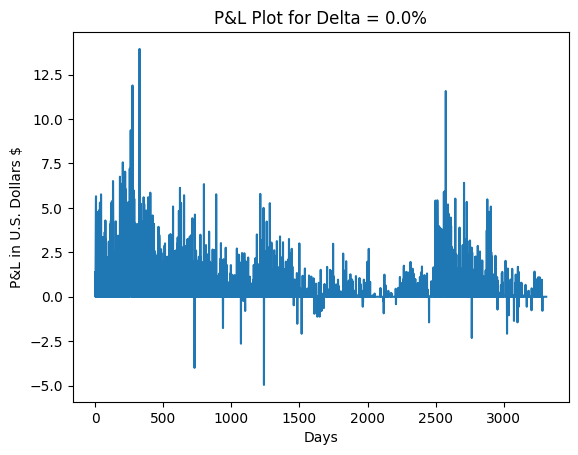

In [170]:
data_train['stoploss_pnl'] = plot_best_delta_strategy(data_train, strategy="stoploss")

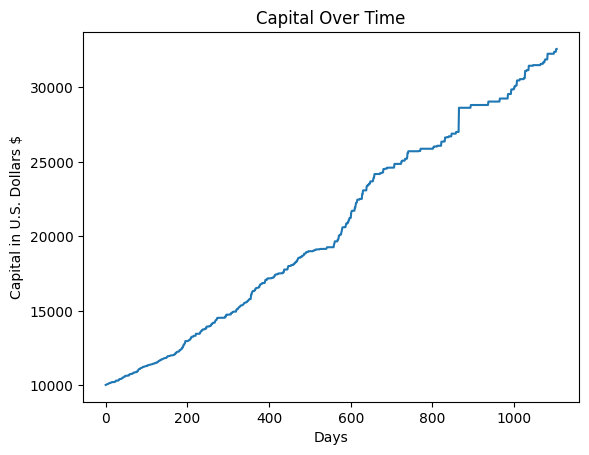

Capital = 32572.03448105819
Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.453
        ===> Sum PnL = 568.750
        ===> Average PNL = 0.494$
        ===> Std PNL = 1.091
        ===> Final Capital = 32572.03$
        ===> Annualized Return = 30.905%
        ===> Profitable Days = 32.22%
        ===> Lossy Days = 0.72%
        ===> Neutral Days = 67.06%
        


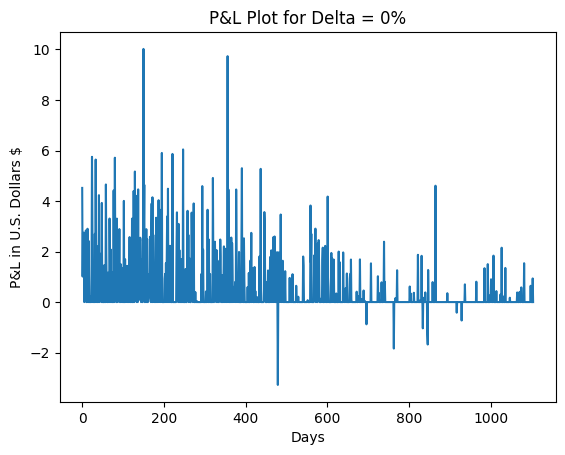

In [171]:
data_test['stoploss_pnl'] = plot_best_delta_strategy(data_test, tune=False, strategy="stoploss", delta_percents=[0], plot_capital=True)

#### Capital Optimization

Exploring various deltas for the stoploss strategy....

Best Delta for stoploss Strategy = 0.0%,
                ===> Sharpe Ratio = 0.455
                ===> Sum PnL = 1760.640
                ===> Average PNL = 0.510$
                ===> Std PNL = 1.120
                ===> Best Final Capital = 249393.74$
                ===> Annualized Return = 27.709%
                ===> Profitable Days = 33.04%
                ===> Lossy Days = 0.91%
                ===> Neutral Days = 66.05%
                


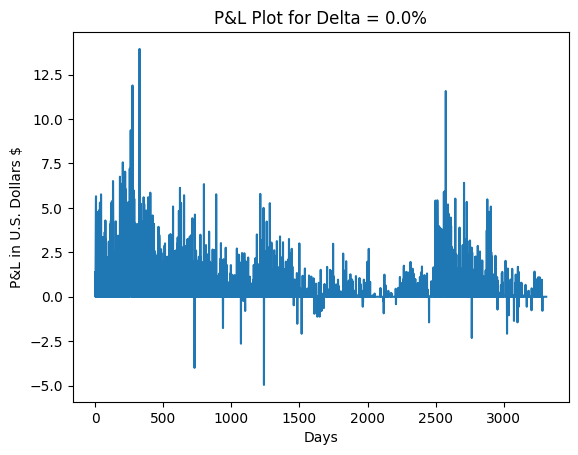

In [172]:
data_train['stoploss_pnl_capital'] = plot_best_delta_strategy(data_train, optimize="capital", strategy="stoploss")

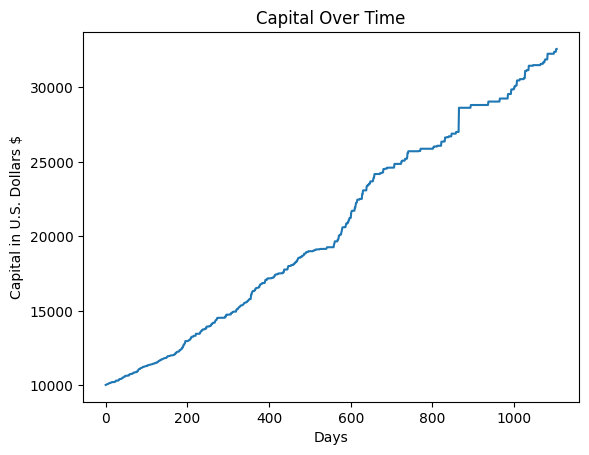

Capital = 32572.03448105819
Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.453
        ===> Sum PnL = 568.750
        ===> Average PNL = 0.494$
        ===> Std PNL = 1.091
        ===> Final Capital = 32572.03$
        ===> Annualized Return = 30.905%
        ===> Profitable Days = 32.22%
        ===> Lossy Days = 0.72%
        ===> Neutral Days = 67.06%
        


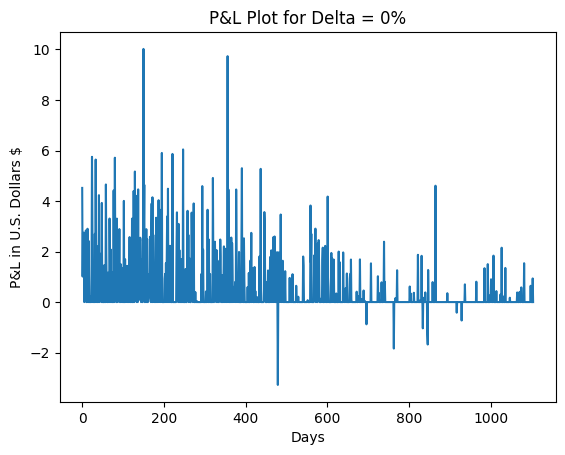

In [173]:
data_test['stoploss_pnl_capital'] = plot_best_delta_strategy(data_test, optimize="capital", tune=False, strategy="stoploss", delta_percents=[0], plot_capital=True)

### Long + Short Strat

In [185]:
def long_short_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, max_cap_alloc=50000, plot_capital=False, initial_capital=10000):
    pnl = []

    capital = initial_capital

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        pred_low_delta = day_info["pred_low_open"]
        actual_low_delta = day_info["actual_low_open"]

        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        day_return_short = 0
        
        # Long Trade
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(open-close)
        else:
            pnl.append(0)
            num_neutral_days += 1

        if pred_low_delta <= delta:
            if actual_low_delta <= pred_low_delta:
                day_return_short = pred_low_delta * -1
                # Shouldn't be able to short beyond max_cap_alloc
                capital_to_short = min((capital * (1-cap_alloc_limit)), max_cap_alloc)
                num_shares = math.floor(capital_to_short / open)
                capital += num_shares * day_return_short
                pnl[-1] += pred_low_delta * -1
            else:
                day_return_short = (open-close) * -1
                # Shouldn't be able to short beyond max_cap_alloc
                capital_to_short = min((capital * (1-cap_alloc_limit)), max_cap_alloc)
                num_shares = math.floor(capital_to_short / open)
                capital += num_shares * day_return_short
                pnl[-1] += day_return_short * -1

        if day_return + day_return_short > 0:
            num_profit_days += 1
        elif day_return + day_return_short < 0:
            num_loss_days += 1
        else:
            num_neutral_days += 1
        capital_list.append(capital)

    if plot_capital:    
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)
    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

#### Sharpe Ratio Optimization

Exploring various deltas for the long_short strategy....

Best Delta for long_short Strategy = 0.0%,
                ===> Best Sharpe Ratio = 0.274
                ===> Sum PnL = 3818.490
                ===> Average PNL = 1.106$
                ===> Std PNL = 4.031
                ===> Final Capital = 1395404.16$
                ===> Annualized Return = 40.354%
                ===> Profitable Days = 52.98%
                ===> Lossy Days = 6.29%
                ===> Neutral Days = 40.72%
                


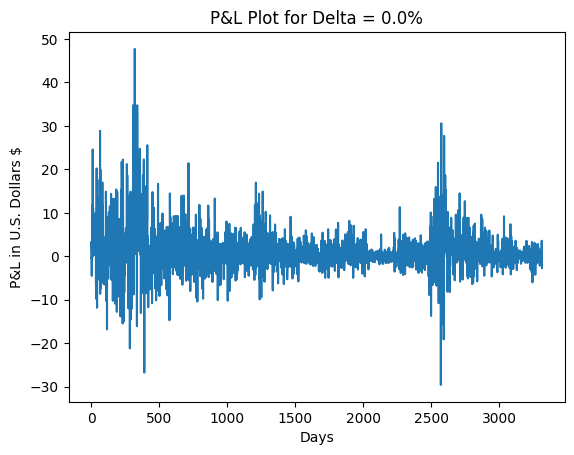

In [186]:
data_train['long_short_pnl'] = plot_best_delta_strategy(data=data_train, strategy="long_short")

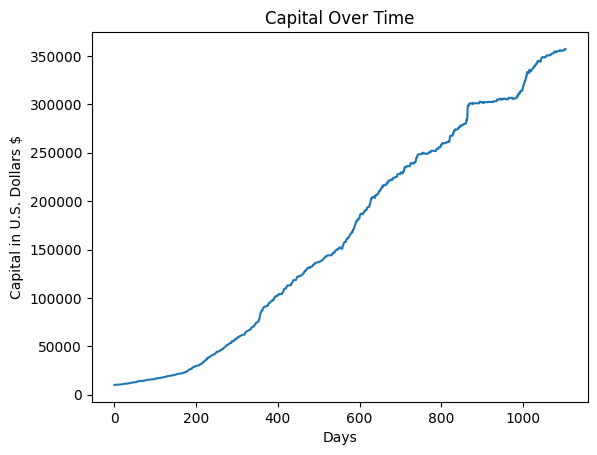

Capital = 357168.8314363603
Delta for long_short Strategy = 0%,
        ===> Sharpe Ratio = 0.335
        ===> Sum PnL = 1465.581
        ===> Average PNL = 1.273$
        ===> Std PNL = 3.796
        ===> Final Capital = 357168.83$
        ===> Annualized Return = 109.548%
        ===> Profitable Days = 52.79%
        ===> Lossy Days = 5.91%
        ===> Neutral Days = 41.30%
        


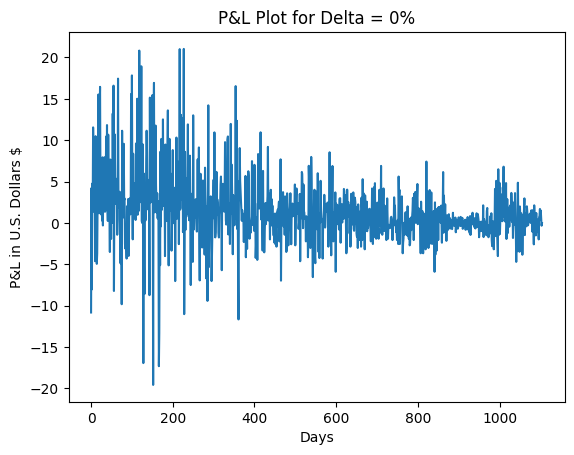

In [187]:
data_test['long_short_pnl'] = plot_best_delta_strategy(data=data_test, tune=False, strategy="long_short", delta_percents=[0], plot_capital=True)

#### Capital Optimization

Exploring various deltas for the long_short strategy....

Best Delta for long_short Strategy = 0.0%,
                ===> Sharpe Ratio = 0.274
                ===> Sum PnL = 3818.490
                ===> Average PNL = 1.106$
                ===> Std PNL = 4.031
                ===> Best Final Capital = 1395404.16$
                ===> Annualized Return = 40.354%
                ===> Profitable Days = 52.98%
                ===> Lossy Days = 6.29%
                ===> Neutral Days = 40.72%
                


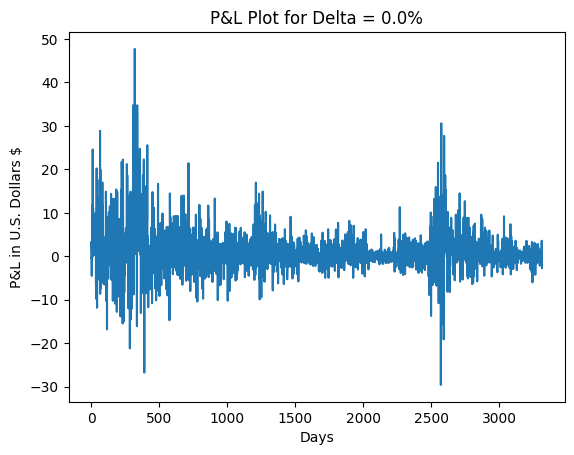

In [188]:
data_train['long_short_pnl_capital'] = plot_best_delta_strategy(data=data_train, strategy="long_short", optimize="capital")

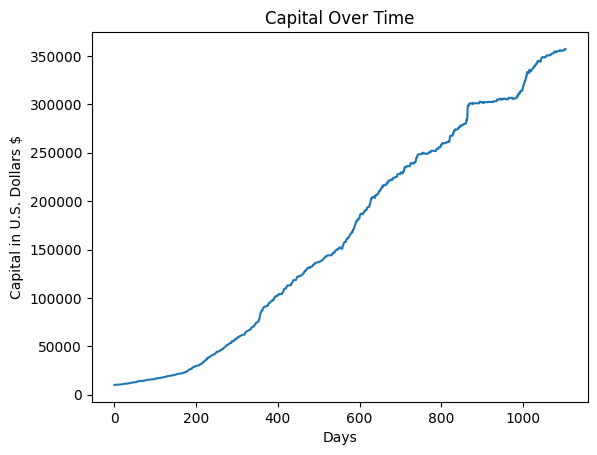

Capital = 357168.8314363603
Delta for long_short Strategy = 0%,
        ===> Sharpe Ratio = 0.335
        ===> Sum PnL = 1465.581
        ===> Average PNL = 1.273$
        ===> Std PNL = 3.796
        ===> Final Capital = 357168.83$
        ===> Annualized Return = 109.548%
        ===> Profitable Days = 52.79%
        ===> Lossy Days = 5.91%
        ===> Neutral Days = 41.30%
        


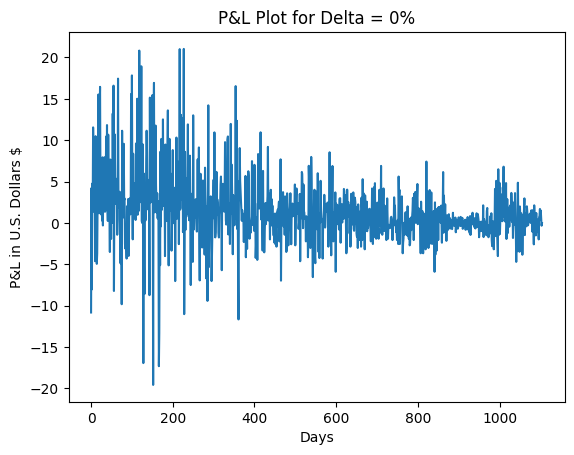

In [178]:
data_test['long_short_pnl_capital'] = plot_best_delta_strategy(data=data_test, optimize="capital", tune=False, strategy="long_short", delta_percents=[0], plot_capital=True)

## Benchmarking and Sanity Checks

In [179]:
data_test["max_profit"] = data_test["High"] - data_test["Low"]

In [180]:
print('Blind strategy')
print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['blind_pnl'].describe())


Blind strategy
Test data:
count    1105.000000
mean        5.155493
std         5.436168
min         0.279999
25%         1.680001
50%         3.279999
75%         6.480003
max        41.119995
Name: max_profit, dtype: float64

count    1105.000000
mean        1.165673
std         2.474882
min        -5.839996
25%         0.000000
50%         0.559998
75%         1.803811
max        17.760010
Name: blind_pnl, dtype: float64


In [181]:
print('Stoploss strategy')
print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['stoploss_pnl'].describe())


Stoploss strategy
Test data:
count    1105.000000
mean        5.155493
std         5.436168
min         0.279999
25%         1.680001
50%         3.279999
75%         6.480003
max        41.119995
Name: max_profit, dtype: float64

count    1105.000000
mean        0.514706
std         1.136951
min        -3.279999
25%         0.000000
50%         0.000000
75%         0.434079
max        10.021722
Name: stoploss_pnl, dtype: float64


In [182]:
print('Long Short strategy')
print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['long_short_pnl'].describe())

Long Short strategy
Test data:
count    1105.000000
mean        5.155493
std         5.436168
min         0.279999
25%         1.680001
50%         3.279999
75%         6.480003
max        41.119995
Name: max_profit, dtype: float64

count    1105.000000
mean        1.326318
std         3.955531
min       -19.600009
25%        -0.426645
50%         0.734266
75%         2.479980
max        21.033363
Name: long_short_pnl, dtype: float64


In [183]:
data_train.to_csv('../data/data_train_val.csv')
data_test.to_csv('../data/data_test.csv')